In [1]:
"""Assumption: Two sensors are similar if they get congested at the same times"""

"""Assumption: A sensor is "congested" if the flow is relatively high (or low speed)"""

"""Assumption: Congested Slot = specific (DayOfWeek, Hour) combination"""

'Assumption: Congested Slot = specific (DayOfWeek, Hour) combination'

In [2]:
"""Imports and Project Setup"""

import sys
import os
import pyspark.sql.functions as F
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import col, udf

sys.path.append(os.path.abspath('..'))
from utils import get_spark_session, PATHS

spark = get_spark_session("Traffic-LSH-Similarity")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/12 21:04:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
"""Load Data"""

print(f"Loading data from: {PATHS['clean_enriched']}")
df = spark.read.parquet(PATHS["clean_enriched"])

df_2019 = df.filter(col("year") == 2019)
print(f"Analyzing {df_2019.count():,} rows of traffic data from 2019.")

Loading data from: hdfs:///user/ubuntu/largest_parquet_clean_enriched/clean_enriched


[Stage 1:========================================================>(84 + 1) / 85]

Analyzing 890,370,845 rows of traffic data from 2019.


In [4]:
"""Creating "Shingles" (Defining the Sets)"""

weekly_profile = (
    df_2019
    .withColumn("day_of_week", F.dayofweek("timestamp"))
    .withColumn("hour", F.hour("timestamp"))
    .groupBy("sensor_id", "day_of_week", "hour")
    .agg(F.avg("value").alias("avg_flow"))
)

# 7 zile * 24 ore = 168 time sloturi posibile
# (day, hour) -> index in [0,167]
weekly_profile = weekly_profile.withColumn(
    "time_slot_idx", 
    (col("day_of_week") - 1) * 24 + col("hour")
)

global_avg = weekly_profile.select(F.avg("avg_flow")).collect()[0][0]
print(f"Global Average Flow: {global_avg:.2f}")

# daca un senzor are 1.5 * global average => am un feature
high_traffic_slots = (
    weekly_profile
    .filter(col("avg_flow") > (global_avg * 1.5))
    .groupBy("sensor_id")
    .agg(F.collect_list("time_slot_idx").alias("active_slots"))
)

high_traffic_slots.show(5, truncate=False)

Global Average Flow: 239.93


+---------+--------------------+
|sensor_id|active_slots        |
+---------+--------------------+
|1000210  |[137, 135, 134, 136]|
|1000910  |[136, 135]          |
|1001210  |[14, 15, 136, 135]  |
|1001510  |[13, 14, 135, 15]   |
|1001710  |[13, 15, 14]        |
+---------+--------------------+
only showing top 5 rows



In [5]:
"""Vectorization (Preparing for MinHash)"""

from pyspark.ml.linalg import Vectors, VectorUDT

NUM_FEATURES = 7 * 24

def indices_to_vector(indices):
    indices.sort()
    return Vectors.sparse(NUM_FEATURES, indices, [1.0] * len(indices))

make_vector_udf = udf(indices_to_vector, VectorUDT())

vector_df = high_traffic_slots.withColumn(
    "features", 
    make_vector_udf(col("active_slots"))
).select("sensor_id", "features")

vector_df.show(5)

[Stage 21:>                                                         (0 + 1) / 1]

+---------+--------------------+
|sensor_id|            features|
+---------+--------------------+
|  1000210|(168,[134,135,136...|
|  1000910|(168,[135,136],[1...|
|  1001210|(168,[14,15,135,1...|
|  1001510|(168,[13,14,15,13...|
|  1001710|(168,[13,14,15],[...|
+---------+--------------------+
only showing top 5 rows



In [6]:
"""MinHashing & LSH Model"""

# definesc modelul lsh
mh = MinHashLSH(
    inputCol="features", 
    outputCol="hashes", 
    numHashTables=5
)

# creez signature pentru fiecare senzor
model = mh.fit(vector_df)

# calculez hash values
hashed_df = model.transform(vector_df)

print("MinHash Signatures created:")
hashed_df.select("sensor_id", "hashes").show(5, truncate=False)

MinHash Signatures created:


[Stage 33:>                                                         (0 + 1) / 1]

+---------+-------------------------------------------------------------------------------+
|sensor_id|hashes                                                                         |
+---------+-------------------------------------------------------------------------------+
|1000210  |[[6.48171681E8], [2.84581693E8], [9.740592E7], [6.23740345E8], [1.196858462E9]]|
|1000910  |[[1.012582659E9], [2.84581693E8], [9.740592E7], [8.349411E8], [1.423582122E9]] |
|1001210  |[[2.68666651E8], [1.84945526E8], [9.740592E7], [1.80143503E8], [3.2409858E8]]  |
|1001510  |[[2.68666651E8], [1.84945526E8], [9.740592E7], [1.80143503E8], [3.2409858E8]]  |
|1001710  |[[2.68666651E8], [1.84945526E8], [1.17838301E8], [1.80143503E8], [3.2409858E8]]|
+---------+-------------------------------------------------------------------------------+
only showing top 5 rows



In [7]:
"""Similarity Search (The "Approximate" Join)"""

print("Running Approximate Similarity Join (LSH)...")

# caut perechi de senzori similari
matches = model.approxSimilarityJoin(
    hashed_df, 
    hashed_df, 
    threshold=0.3,
    distCol="JaccardDistance"
)

# filtrez perechile de tip identitate
final_matches = (
    matches
    .filter(col("datasetA.sensor_id") < col("datasetB.sensor_id"))
    .select(
        col("datasetA.sensor_id").alias("Sensor_A"),
        col("datasetB.sensor_id").alias("Sensor_B"),
        col("JaccardDistance")
    )
    .orderBy("JaccardDistance")
)

print(f"Found {final_matches.count()} similar pairs.")
final_matches.show(10)

Running Approximate Similarity Join (LSH)...


Found 4231500 similar pairs.


[Stage 64:====================================================>   (13 + 1) / 14]

+--------+--------+---------------+
|Sensor_A|Sensor_B|JaccardDistance|
+--------+--------+---------------+
|10115310|  601351|            0.0|
|10115310|  312896|            0.0|
| 1113267| 1114018|            0.0|
| 1017710| 1111561|            0.0|
| 1019710|  315955|            0.0|
|10117110| 1211627|            0.0|
| 1111549|  401811|            0.0|
| 1000710|  819532|            0.0|
| 1108353|  318773|            0.0|
|10117110| 1211629|            0.0|
+--------+--------+---------------+
only showing top 10 rows



Visualizing match: Sensor 1000310 vs 817755 (Similarity: 100.0%)


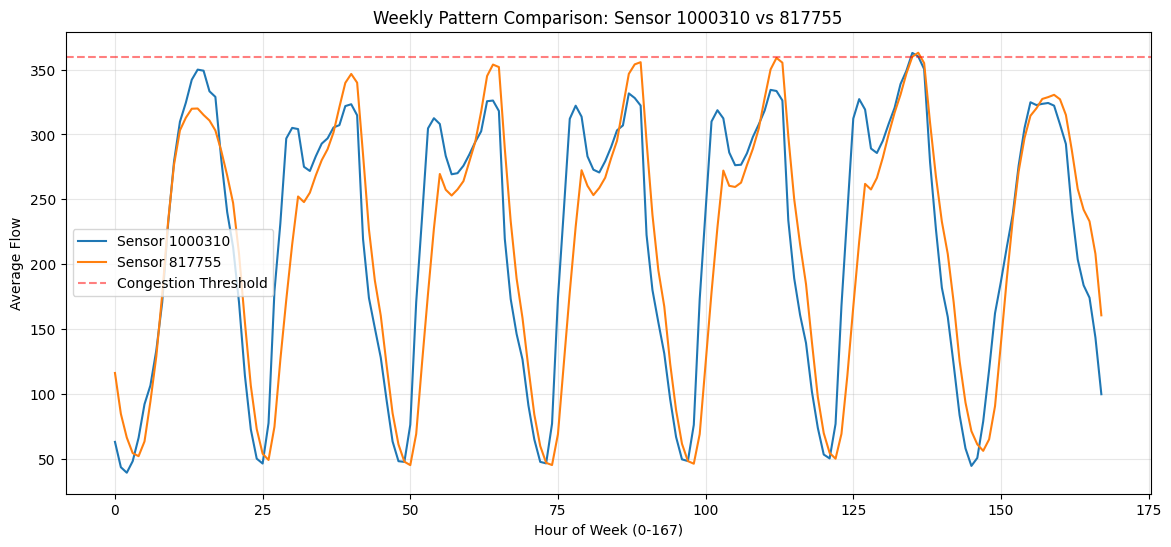

In [8]:
"""Verification & Visualization"""

import matplotlib.pyplot as plt

best_match = final_matches.first()

if best_match:
    sensor_a = best_match["Sensor_A"]
    sensor_b = best_match["Sensor_B"]
    score = 1 - best_match["JaccardDistance"]
    
    print(f"Visualizing match: Sensor {sensor_a} vs {sensor_b} (Similarity: {score:.1%})")

    plot_data = (
        weekly_profile
        .filter(col("sensor_id").isin([sensor_a, sensor_b]))
        .orderBy("time_slot_idx")
        .toPandas()
    )

    plt.figure(figsize=(14, 6))
    
    for s_id in [sensor_a, sensor_b]:
        subset = plot_data[plot_data["sensor_id"] == s_id]
        plt.plot(subset["time_slot_idx"], subset["avg_flow"], label=f"Sensor {s_id}")

    plt.axhline(global_avg * 1.5, color='r', linestyle='--', alpha=0.5, label="Congestion Threshold")
    
    plt.xlabel("Hour of Week (0-167)")
    plt.ylabel("Average Flow")
    plt.title(f"Weekly Pattern Comparison: Sensor {sensor_a} vs {sensor_b}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No matches found with the current threshold.")